In [25]:
import os
import re
import glob
import time
import json
import pandas as pd
import hashlib

from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from collections import defaultdict

In [2]:
y_exh = pd.read_parquet('/root/data/y_train.parquet' )

In [3]:
y_cols = list(y_exh.columns)

In [27]:
part_to_type = { x: re.sub('ЭКСГАУСТЕРА №\d|ЭКСГ\. ?№\d|\ №[4-9]$|ЭКСГ[4-9]','', x.split('_')[2]).strip()  for x in y_cols}

In [32]:
part_types = list(set([part_to_type[x] for x in part_to_type]))

In [57]:
with open('/root/model/part_types.json', 'wb') as f:
    f.write( json.dumps(part_types).encode('utf-8') )

In [56]:
with open('/root/model/part_to_type.json', 'wb') as f:
    f.write( json.dumps(part_to_type).encode('utf-8') )

In [4]:
with open('/root/model/Y_columns.json', 'rb') as f:
    Y_columns = json.loads( f.read().decode('utf-8') ) 

In [5]:
with open('/root/model/part_types.json', 'rb') as f:
    part_types = json.loads( f.read().decode('utf-8') )
    
with open('/root/model/part_to_type.json', 'rb') as f:
    part_to_type = json.loads( f.read().decode('utf-8') )

In [20]:
remove = ['ТОК РОТОРА 2', 'ТОК РОТОРА2',]

In [24]:
model_paths = {}
model_saw_exh = {}

for exh in range(4, 10):
    X_exh = pd.read_parquet( '/root/sep_data/X_exhauster%s_train.parquet' % exh )
    
    cols_rename = [x[14:] for x in X_exh.columns]

    X_exh.columns = cols_rename

    cols = [x for x in X_exh.columns if x not in remove]

    x1 = X_exh[ cols ].rolling(window='30D').agg(['max', 'sem', 'kurt', 'std', 'skew']).fillna(0)

    y_exh = pd.read_parquet('/root/sep_data/Y_exhauster%s_train.parquet' % exh )

    models = {}
    for x in range(len(y_exh.columns)):
        col = y_exh.columns[x]

        label_0 = y_exh[[ col ]][ y_exh[ col ] == 0 ].count().values[0]
        label_2 = y_exh[[ col ]][ y_exh[ col ] == 2 ].count().values[0]
        attitude = label_2/(label_0+label_2)
    
        if attitude < 0.05:
            print('Skipped target: %s' % col)
            continue
        
        print('Processing target: %s' % col )
        start = time.time()
        splitted_data = train_test_split(x1, y_exh[col].map({0: 0, 1: 1, 2: 1}), test_size=0.3)
        X_train, X_test, y_train, y_test = splitted_data
    
        train_pool = Pool(X_train, y_train)
        test_pool = Pool(X_test, y_test)
        model = CatBoostClassifier(learning_rate=0.01, iterations=100, depth=3, loss_function='Logloss', eval_metric='Accuracy')

        part_type = part_to_type[ col ]

        if model_paths.get(part_type):
            init_model = model.load_model( model_paths.get(part_type) )        
            model.fit(train_pool, eval_set=test_pool, verbose=False, init_model=init_model)            
            model_saw_exh[part_type].append(exh)
            model.save_model( model_paths.get(part_type) )

        else:
            model.fit(train_pool, eval_set=test_pool, verbose=False)
            model_path = '/root/model/%s.cb' % (hashlib.sha256(part_type.encode('utf-8')).hexdigest()) 
            model_paths[part_type] = model_path
            model.save_model(model_path)
            model_saw_exh[part_type] = [exh]

            
        print('Accuracy', model.best_score_.get('learn').get('Accuracy'))
        
        
        print('Done. Spended time: %s' % (time.time() - start) ) 

    
itn = json.dumps(index_to_name)
with open('/root/model/index_to_target.json' , 'wb') as f:
    f.write( itn.encode('utf-8') )

mp = json.dumps(model_paths)
with open('/root/model/model_paths.json', 'wb') as f:
    f.write( mp.encode('utf-8') )        
        

Processing target: Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4
Accuracy 0.9704761923708892
Done. Spended time: 32.533084869384766
Processing target: Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4
Accuracy 0.9994137292041056
Done. Spended time: 31.891507625579834
Processing target: Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4
Accuracy 0.9940315459904265
Done. Spended time: 29.47403883934021
Processing target: Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4
Accuracy 0.9538615136866149
Done. Spended time: 31.819332599639893
Processing target: Y_ЭКСГАУСТЕР А/М №4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №4
Accuracy 0.9993056876531003
Done. Spended time: 29.498658180236816
Processing target: Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4
Accuracy 0.9982313934773815
Done. Spended time: 31.710575819015503
Processing target: Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4
Accuracy 0.9945726719456034
Done. Spended time: 30.16280460357666
Processing target: Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4
Accu

Training has stopped (degenerate solution on iteration 7, probably too small l2-regularization, try to increase it)


Accuracy 0.4992552631615192
Done. Spended time: 11.871073722839355
Skipped target: Y_ЭКСГАУСТЕР А/М №6_ГАЗОВАЯ ЗАДВИЖКА ЭКСГАУСТЕРА А/М №6
Skipped target: Y_ЭКСГАУСТЕР А/М №6_ЭКСГАУСТЕР А/М №6
Processing target: Y_ЭКСГАУСТЕР А/М №6_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №6
Accuracy 0.9930538158638358
Done. Spended time: 31.802082300186157
Skipped target: Y_ЭКСГАУСТЕР А/М №6_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ6 ВУ1
Skipped target: Y_ЭКСГАУСТЕР А/М №6_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №6
Skipped target: Y_ЭКСГАУСТЕР А/М №6_МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (ПУСК.) ЭКСГ.№6
Skipped target: Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№6 Т.3
Skipped target: Y_ЭКСГАУСТЕР А/М №6_МАСЛОПРОВОДЫ ЭКСГ №6
Skipped target: Y_ЭКСГАУСТЕР А/М №6_КЛ1 ТР№6 ДО ЭД ЭКСГАУСТЕРА №6
Skipped target: Y_ЭКСГАУСТЕР А/М №6_КЛ2 ТР№6 ДО ЭД ЭКСГАУСТЕРА №6
Skipped target: Y_ЭКСГАУСТЕР А/М №6_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№6 Т.2
Processing target: Y_ЭКСГАУСТЕР А/М №7_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №7
Accuracy 0.9903787927

Training has stopped (degenerate solution on iteration 4, probably too small l2-regularization, try to increase it)


Accuracy 0.9393403313447669
Done. Spended time: 11.325760841369629
Processing target: Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №7
Accuracy 0.9786709756779493
Done. Spended time: 32.91871666908264
Skipped target: Y_ЭКСГАУСТЕР А/М №7_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№7 Т.3
Processing target: Y_ЭКСГАУСТЕР А/М №7_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №7
Accuracy 0.852000980025627
Done. Spended time: 31.97524857521057
Skipped target: Y_ЭКСГАУСТЕР А/М №7_ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР.МАСЛО
Processing target: Y_ЭКСГАУСТЕР А/М №7_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №7
Accuracy 0.9833264034727554
Done. Spended time: 33.33230638504028
Processing target: Y_ЭКСГАУСТЕР А/М №7_ГСМ ЭКСГ. №7
Accuracy 0.8027955521772592
Done. Spended time: 31.48665499687195
Processing target: Y_ЭКСГАУСТЕР А/М №7_КОЖУХ МУФТЫ ЭКСГ. №7
Accuracy 0.936826299333555
Done. Spended time: 34.05499768257141
Skipped target: Y_ЭКСГАУСТЕР А/М №7_ЭКСГАУСТЕР А/М №7
Processing target: Y_ЭКСГАУСТЕР А/М №7_МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №7
Accuracy 0.

Training has stopped (degenerate solution on iteration 78, probably too small l2-regularization, try to increase it)


Accuracy 0.9752488437182025
Done. Spended time: 23.388596773147583
Processing target: Y_ЭКСГАУСТЕР А/М №8_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №8
Accuracy 0.9112625359188421
Done. Spended time: 32.985491037368774
Processing target: Y_ЭКСГАУСТЕР А/М №8_КОРПУС ЭКСГ. №8
Accuracy 0.8753569311792154
Done. Spended time: 34.22834086418152
Processing target: Y_ЭКСГАУСТЕР А/М №8_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №8


Training has stopped (degenerate solution on iteration 2, probably too small l2-regularization, try to increase it)


Accuracy 0.7313640184601079
Done. Spended time: 11.267544269561768
Processing target: Y_ЭКСГАУСТЕР А/М №8_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№8 Т.3
Accuracy 0.991468543304538
Done. Spended time: 33.11807656288147
Processing target: Y_ЭКСГАУСТЕР А/М №8_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№8 Т.4
Accuracy 0.9939942058509856
Done. Spended time: 31.85653829574585
Skipped target: Y_ЭКСГАУСТЕР А/М №8_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №8
Processing target: Y_ЭКСГАУСТЕР А/М №8_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №8
Accuracy 0.9644529524190213
Done. Spended time: 32.11898636817932
Skipped target: Y_ЭКСГАУСТЕР А/М №8_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ СПВД-М10-400-5
Processing target: Y_ЭКСГАУСТЕР А/М №8_КЛ2 ТР№8 ДО ЭД ЭКСГАУСТЕРА №8
Accuracy 0.9980249514769479
Done. Spended time: 32.272297859191895
Processing target: Y_ЭКСГАУСТЕР А/М №8_КЛ1 ТР№8 ДО ЭД ЭКСГАУСТЕРА №8
Accuracy 0.9978789576530682
Done. Spended time: 32.32676362991333
Skipped target: Y_ЭКСГАУСТЕР А/М №8_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.2
Processing t

Training has stopped (degenerate solution on iteration 2, probably too small l2-regularization, try to increase it)


Accuracy 0.7410677106806419
Done. Spended time: 11.428849935531616
Processing target: Y_ЭКСГАУСТЕР А/М №9_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №9
Accuracy 0.9290012446203035
Done. Spended time: 32.46217584609985
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ЭЛ/ДВИГАТЕЛЬ ГАЗ. ЗАДВИЖКИ ЭКСГ. №9
Processing target: Y_ЭКСГАУСТЕР А/М №9_ЭЛЕКТРООБОРУДОВАНИЯ ЭКСГАУСТЕРА №9
Accuracy 0.9959945048781679
Done. Spended time: 31.03377366065979
Processing target: Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №9
Accuracy 0.9814107318927487
Done. Spended time: 32.08033800125122
Processing target: Y_ЭКСГАУСТЕР А/М №9_РОТОР ЭКСГ. №9


Training has stopped (degenerate solution on iteration 2, probably too small l2-regularization, try to increase it)


Accuracy 0.8501408595547066
Done. Spended time: 10.935760259628296
Processing target: Y_ЭКСГАУСТЕР А/М №9_ТР-Р ТМ-6300-10/6 ЭКСГ. №9
Accuracy 0.994172795780197
Done. Spended time: 32.513999223709106
Processing target: Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №9
Accuracy 0.9886839483157378
Done. Spended time: 33.87525486946106
Processing target: Y_ЭКСГАУСТЕР А/М №9_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №9


Training has stopped (degenerate solution on iteration 1, probably too small l2-regularization, try to increase it)


Accuracy 0.7669280527438651
Done. Spended time: 11.127182722091675
Processing target: Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ №2
Accuracy 0.9879775463335273
Done. Spended time: 32.1440851688385
Processing target: Y_ЭКСГАУСТЕР А/М №9_ГСМ ЭКСГ. №9
Accuracy 0.9166372204979614
Done. Spended time: 33.012354612350464
Processing target: Y_ЭКСГАУСТЕР А/М №9_КОЖУХ МУФТЫ ЭКСГ. №9


Training has stopped (degenerate solution on iteration 32, probably too small l2-regularization, try to increase it)


Accuracy 0.37862962606451916
Done. Spended time: 16.887689352035522
Processing target: Y_ЭКСГАУСТЕР А/М №9_ПОДШИПНИК ОПОРНЫЙ №1
Accuracy 0.9592098765280954
Done. Spended time: 32.30185317993164
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ЗАДВИЖКА ЭКСГ. №9
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№9 Т.1
Skipped target: Y_ЭКСГАУСТЕР А/М №9_МАСЛОПРОВОДЫ ЭКСГАУСТЕРА №9
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ТИРИСТОРНЫЙ ВОЗБУДИТЕЛЬ ТВ-400 ЭКСГ9 ВУ1
Skipped target: Y_ЭКСГАУСТЕР А/М №9_МЕТРАН-100 ДАТЧИКИ ДАВЛЕНИЯ ЭКСГ.№9
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ТСМТ-101-010-50М-80 ТЕРМОПРЕОБР.МАСЛО
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ТСМТ-101-010-50М-400 ТЕРМОПР.ПОДШ.Т.1
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ЭКСГАУСТЕР А/М №9
Skipped target: Y_ЭКСГАУСТЕР А/М №9_ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА ЭКСГ. №9


NameError: name 'index_to_name' is not defined

In [38]:
mp = json.dumps(model_paths)
with open('/root/model/model_paths.json', 'wb') as f:
    f.write( mp.encode('utf-8') )

In [29]:
target_col_data = {
    "exhauster4": slice(93,116), 
    "exhauster5": slice(28,62),
    "exhauster6": slice(148,175),
    "exhauster7": slice(116,148),
    "exhauster8": slice(62,93),
    "exhauster9": slice(0,28),
}

In [26]:
with open('/root/model/part_types.json', 'rb') as f:
    part_types = json.loads( f.read().decode('utf-8') )
    
with open('/root/model/part_to_type.json', 'rb') as f:
    part_to_type = json.loads( f.read().decode('utf-8') )

with open('/root/model/model_paths.json', 'rb') as f:
    model_paths = json.loads( f.read().decode('utf-8') )

In [27]:
with open('/root/model/Y_columns.json', 'rb') as f:
    Y_columns = json.loads( f.read().decode('utf-8') ) 

In [34]:
remove = ['ТОК РОТОРА 2', 'ТОК РОТОРА2',]

In [51]:
y_result = pd.read_parquet('/root/sep_data/X_exhauster4_test.parquet').reset_index()[['DT']]

In [ ]:
for x in target_col_data:
    print(x)
    for y in Y_columns[ target_col_data[ x ] ]:
        pt = part_to_type[y]
        if os.path.exists('/root/model/%s.cb' % (hashlib.sha256(pt.encode('utf-8')).hexdigest()) ):
            print(pt)
            
    
            model = CatBoostClassifier(learning_rate=0.01, iterations=100, depth=3, loss_function='Logloss', eval_metric='Accuracy')
            model = model.load_model('/root/model/%s.cb' % (hashlib.sha256(pt.encode('utf-8')).hexdigest()))

            df = pd.read_parquet('/root/sep_data/X_%s_test.parquet' % x)
            cols_rename = [x[14:] for x in df.columns]

            df.columns = cols_rename
        
            cols = [x for x in df.columns if x not in remove]
            x1 = df[ cols ].rolling(window='30D').agg(['max', 'sem', 'kurt', 'std', 'skew']).fillna(0)

            y_pred = model.predict(x1)
            y_result[y] = y_pred

        

exhauster4
ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4
ПОДШИПНИК ОПОРНЫЙ
УЛИТА
РЕДУКТОР ГАЗ. ЗАДВИЖКИ
МАСЛОНАСОС РАБОЧИЙ
ЭЛЕКТРОАППАРАТУРА
ПОДШИПНИК ОПОРНЫЙ №2
ЗАДВИЖКА
ГСМ
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ  Т.1
РОТОР
МАСЛООХЛАДИТЕЛЬ  М-05-1
ПОДШИПНИК ОПОРНО-УПОРНЫЙ
ПОДШИПНИК ОПОРНЫЙ №1
КЛ1 ТР№4 ДО ЭД
КЛ2 ТР№4 ДО ЭД
ТР-Р ТМ-4000-10/6
exhauster5
МАСЛООХЛАДИТЕЛЬ  М-05-1
ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4
КОРПУС
ЗАДВИЖКА
ПОДШИПНИК ОПОРНЫЙ
ПОДШИПНИК ОПОРНЫЙ №2
ПОДШИПНИК ОПОРНО-УПОРНЫЙ
МАСЛОНАСОС ШЕСТЕРЕНЧАТЫЙ (РЕЗ.)
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ  Т.1
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ  Т.3
ЭЛЕКТРООБОРУДОВАНИЯ
ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ  Т.2
ПОДШИПНИК ОПОРНЫЙ №1
РЕДУКТОР ГАЗ. ЗАДВИЖКИ
ЗАПОРНАЯ АРМАТУРА
МАСЛОПРОВОДЫ
ГСМ
ТР-Р ТМ-4000-10/6
КЛ1 ТР№5 ДО ЭД
КЛ2 ТР№5 ДО ЭД
МАСЛОНАСОС РАБОЧИЙ
РОТОР
ДВИГАТЕЛЬ ПУСКОВОГО МАСЛОНАСОСА
КОЖУХ МУФТЫ
exhauster6
ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4
КОРПУС
ЗАДВИЖКА
ПОДШИПНИК ОПОРНЫЙ №2
РЕДУКТОР ГАЗ. ЗАДВИЖКИ
ПОДШИПНИК ОПОРНО-УПОРНЫЙ
МАСЛОБАК
ПОДШИПНИК ОПОРНЫЙ №1
КОЖУХ МУФТЫ
РОТОР
ТР-Р ТМ-400

In [ ]:
y_result.to_parquet('/root/model/y_pred.parquet')

In [55]:
!ls -lha /root/model/y_pred.parquet

-rw-r--r-- 1 root root 25M May 26 00:44 /root/model/y_pred.parquet


In [63]:
y_result.columns.values

array(['DT',
       'Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ГСМ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№4 Т.1',
       'Y_ЭКСГАУСТЕР А/М №4_РОТОР ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №1 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_КЛ1 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
       'Y_ЭКСГАУСТЕР А/М №4_КЛ2 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
       'Y_ЭКСГАУСТЕР А/М №4_ТР-Р ТМ-4000-10/6 ЭКСГ. №4',
       

In [58]:
yy = y_result.copy()

In [59]:
yy.index = yy['DT']

<Axes: xlabel='DT'>

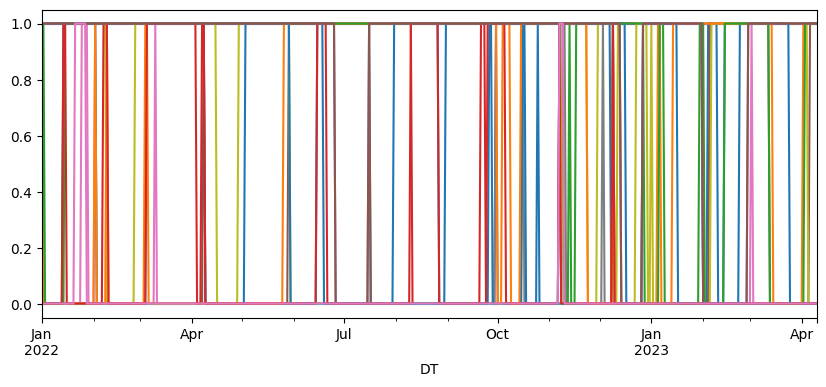

In [70]:
yy[['Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ГСМ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№4 Т.1',
       'Y_ЭКСГАУСТЕР А/М №4_РОТОР ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №1 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_КЛ1 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
       'Y_ЭКСГАУСТЕР А/М №4_КЛ2 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
       'Y_ЭКСГАУСТЕР А/М №4_ТР-Р ТМ-4000-10/6 ЭКСГ. №4',]].resample('1D').max().plot(legend=False, figsize=(10,4))

In [77]:
yy[['Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ГСМ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№4 Т.1',
       'Y_ЭКСГАУСТЕР А/М №4_РОТОР ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №1 ЭКСГ. №4',
       'Y_ЭКСГАУСТЕР А/М №4_КЛ1 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
       'Y_ЭКСГАУСТЕР А/М №4_КЛ2 ТР№4 ДО ЭД ЭКСГАУСТЕРА №4',
       'Y_ЭКСГАУСТЕР А/М №4_ТР-Р ТМ-4000-10/6 ЭКСГ. №4',]].sum() / yy.count().values[0]

Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОДВИГАТЕЛЬ ДСПУ-140-84-4 ЭКСГ. №4     0.901264
Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ ЭКСГ. №4                  0.000000
Y_ЭКСГАУСТЕР А/М №4_УЛИТА ЭКСГ. №4                              1.000000
Y_ЭКСГАУСТЕР А/М №4_РЕДУКТОР ГАЗ. ЗАДВИЖКИ ЭКСГ. №4             0.888493
Y_ЭКСГАУСТЕР А/М №4_МАСЛОНАСОС РАБОЧИЙ ЭКСГ. №4                 1.000000
Y_ЭКСГАУСТЕР А/М №4_ЭЛЕКТРОАППАРАТУРА ЭКСГ. №4                  0.184379
Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №2 ЭКСГ. №4               0.006631
Y_ЭКСГАУСТЕР А/М №4_ЗАДВИЖКА ЭКСГ. №4                           0.000707
Y_ЭКСГАУСТЕР А/М №4_ГСМ ЭКСГ. №4                                0.429108
Y_ЭКСГАУСТЕР А/М №4_ВК 310С ВИБРОПРЕОБРАЗОВАТЕЛЬ ЭКСГ.№4 Т.1    0.000000
Y_ЭКСГАУСТЕР А/М №4_РОТОР ЭКСГ. №4                              0.394901
Y_ЭКСГАУСТЕР А/М №4_МАСЛООХЛАДИТЕЛЬ  М-05-1 ЭКСГ. №4            0.505746
Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНО-УПОРНЫЙ ЭКСГ. №4           0.802012
Y_ЭКСГАУСТЕР А/М №4_ПОДШИПНИК ОПОРНЫЙ №1 ЭКСГ. №4  